## Supplementary 4. Demo of using GP to estimate the function relating decode to actual position

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import spyglass as nd
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
from scipy import linalg
import os
import pickle
import matplotlib.pyplot as plt
from ripple_detection.core import segment_boolean_series

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SpikeSortingRecording,SpikeSortingRecordingSelection)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, RawPosition, IntervalLinearizedPosition, TrackGraph

from spyglass.shijiegu.Analysis_SGU import TrialChoice,EpochPos,MUA,get_linearization_map
from spyglass.shijiegu.decodeHelpers import runSessionNames
from spyglass.shijiegu.ripple_add_replay import plot_decode_spiking,select_subset_helper
from spyglass.shijiegu.changeOfMind import (find_turnaround_time, findProportion,
            find_trials, load_epoch_data_wrapper, find_direction, find_trials_animal)
from spyglass.shijiegu.changeOfMind_triggered import turnaround_triggered_position, turnaround_triggered_decode
from spyglass.shijiegu.load import load_decode

[2025-03-26 12:49:56,248][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-03-26 12:49:56,416][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[12:50:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[12:50:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[12:50:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[12:50:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [4]:
from spyglass.shijiegu.changeOfMind_triggered import (find_triggered_animal, form_null_model, classify_trial,
    plot_physical_vs_mental_position, parse_to_transitions, find_large_position_minus_decode_trials)

In [5]:
triggered_positions_nb = {}
triggered_positions_abs_nb = {}
triggered_decodes_nb = {}
triggered_decodes_baseoff_nb = {}
triggered_decodes_abs_nb = {}
triggered_trial_info_nb = {}

triggered_positions = {}
triggered_positions_abs = {}
triggered_decodes = {}
triggered_decodes_baseoff = {}
triggered_decodes_abs = {}
triggered_trial_info = {}

animal = 'Eliot'
#dates_to_plot = ['20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']
dates_to_plot = ['20221021']
encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'

animal = 'Lewis'
dates_to_plot = ['20240109']
encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'

datafolder = f'/cumulus/shijie/behavior_pilot/Batch1/{animal}'

(triggered_positions_nb[animal], triggered_positions_abs_nb[animal],
 triggered_decodes_nb[animal], triggered_decodes_baseoff_nb[animal], triggered_decodes_abs_nb[animal],
 triggered_trial_info_nb[animal]) = find_triggered_animal(animal,dates_to_plot, nearby = 1,
                                                                   delta_t_minus = 2,delta_t_plus = 0.5,
                                                                   max_flag = 0, segment_only = True)

(triggered_positions[animal], triggered_positions_abs[animal],
 triggered_decodes[animal], triggered_decodes_baseoff[animal], triggered_decodes_abs[animal],
 triggered_trial_info[animal]) = find_triggered_animal(animal,dates_to_plot, nearby = 0,
                                                                   delta_t_minus = 0,delta_t_plus = 1,
                                                                   max_flag = 0, segment_only = True)

[12:50:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704828052.1085632, 1704828052.886563, 1704828054.0845628], [1704828257.4445243, 1704828258.4205241], [1704828877.3364074], [1704829112.9023628, 1704829116.3723624, 1704829119.7183616], [1704829384.4243116], [1704829415.8103058], [1704829448.3762996], [1704829536.6962829, 1704829538.3682826], [1704829749.162243], [1704829943.5902061]]

 turnaround_times 2 [[1704828052.1085632, 1704828052.886563, 1704828054.0845628], [1704828257.4445243, 1704828258.4205241], [1704828877.3364074], [1704829112.9023628, 1704829116.3723624, 1704829119.7183616], [1704829384.4243116], [1704829415.8103058], [1704829448.3762996], [1704829536.6962829, 1704829538.3682826], [1704829749.162243], [1704829943.5902061]]


[12:50:25][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704832875.3462067], [1704832927.6281667, 1704832930.934164], [1704832960.3581414], [1704833382.313818], [1704833652.1636112, 1704833654.8136091], [1704833717.2495613, 1704833719.2995598], [1704833777.783515, 1704833779.9435134], [1704833806.307493], [1704833839.6934674], [1704834065.1812947, 1704834070.6092906], [1704834306.4191098], [1704834343.3950815, 1704834347.597078, 1704834352.5370743], [1704834434.7750113], [1704834758.656763, 1704834759.7987623]]

 turnaround_times 2 [[1704832875.3462067], [1704832927.6281667, 1704832930.934164], [1704832960.3581414], [1704833382.313818], [1704833652.1636112, 1704833654.8136091], [1704833717.2495613, 1704833719.2995598], [1704833777.783515, 1704833779.9435134], [1704833806.307493], [1704833839.6934674], [1704834065.1812947, 1704834070.6092906], [1704834306.4191098], [1704834343.3950815, 1704834347.597078, 1704834352.5370743], [1704834434.7750113], [1704834758.65

[12:50:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704837038.7182755], [1704837192.2122364, 1704837194.742236, 1704837198.252235], [1704837596.9441335], [1704837632.9981244, 1704837640.1621227, 1704837636.0421238], [1704837762.1920917], [1704837887.7700598], [1704838413.877926], [1704838762.3718376], [1704838942.8837917]]

 turnaround_times 2 [[1704837038.7182755], [1704837192.2122364, 1704837194.742236, 1704837198.252235], [1704837596.9441335], [1704837632.9981244, 1704837640.1621227, 1704837636.0421238], [1704837762.1920917], [1704837887.7700598], [1704838413.877926], [1704838762.3718376], [1704838942.8837917]]


[12:50:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704841702.7633002, 1704841705.9452982, 1704841707.905297], [1704842015.4251127], [1704842082.1930728, 1704842087.2550697], [1704842208.1789973], [1704842384.7308917]]

 turnaround_times 2 [[1704841702.7633002, 1704841705.9452982, 1704841707.905297], [1704842015.4251127], [1704842082.1930728, 1704842087.2550697], [1704842208.1789973], [1704842384.7308917]]


[12:50:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704828052.1085632, 1704828052.886563, 1704828054.0845628], [1704828257.4445243, 1704828258.4205241], [1704828877.3364074], [1704829112.9023628, 1704829116.3723624, 1704829119.7183616], [1704829384.4243116], [1704829415.8103058], [1704829448.3762996], [1704829536.6962829, 1704829538.3682826], [1704829749.162243], [1704829943.5902061]]

 turnaround_times 2 [[1704828052.1085632, 1704828052.886563, 1704828054.0845628], [1704828257.4445243, 1704828258.4205241], [1704828877.3364074], [1704829112.9023628, 1704829116.3723624, 1704829119.7183616], [1704829384.4243116], [1704829415.8103058], [1704829448.3762996], [1704829536.6962829, 1704829538.3682826], [1704829749.162243], [1704829943.5902061]]


[12:50:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704832875.3462067], [1704832927.6281667, 1704832930.934164], [1704832960.3581414], [1704833382.313818], [1704833652.1636112, 1704833654.8136091], [1704833717.2495613, 1704833719.2995598], [1704833777.783515, 1704833779.9435134], [1704833806.307493], [1704833839.6934674], [1704834065.1812947, 1704834070.6092906], [1704834306.4191098], [1704834343.3950815, 1704834347.597078, 1704834352.5370743], [1704834434.7750113], [1704834758.656763, 1704834759.7987623]]

 turnaround_times 2 [[1704832875.3462067], [1704832927.6281667, 1704832930.934164], [1704832960.3581414], [1704833382.313818], [1704833652.1636112, 1704833654.8136091], [1704833717.2495613, 1704833719.2995598], [1704833777.783515, 1704833779.9435134], [1704833806.307493], [1704833839.6934674], [1704834065.1812947, 1704834070.6092906], [1704834306.4191098], [1704834343.3950815, 1704834347.597078, 1704834352.5370743], [1704834434.7750113], [1704834758.65

[12:50:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704837038.7182755], [1704837192.2122364, 1704837194.742236, 1704837198.252235], [1704837596.9441335], [1704837632.9981244, 1704837640.1621227, 1704837636.0421238], [1704837762.1920917], [1704837887.7700598], [1704838413.877926], [1704838762.3718376], [1704838942.8837917]]

 turnaround_times 2 [[1704837038.7182755], [1704837192.2122364, 1704837194.742236, 1704837198.252235], [1704837596.9441335], [1704837632.9981244, 1704837640.1621227, 1704837636.0421238], [1704837762.1920917], [1704837887.7700598], [1704838413.877926], [1704838762.3718376], [1704838942.8837917]]


[12:50:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704841702.7633002, 1704841705.9452982, 1704841707.905297], [1704842015.4251127], [1704842082.1930728, 1704842087.2550697], [1704842208.1789973], [1704842384.7308917]]

 turnaround_times 2 [[1704841702.7633002, 1704841705.9452982, 1704841707.905297], [1704842015.4251127], [1704842082.1930728, 1704842087.2550697], [1704842208.1789973], [1704842384.7308917]]


In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics.pairwise import laplacian_kernel
from sklearn.gaussian_process.kernels import PairwiseKernel

### 1. form null model and overlay estimated intervals on top of data

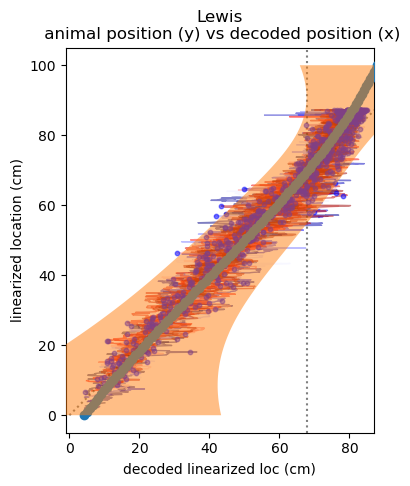

In [13]:
# null model
(positions_nearby, decodes_nearby) = (triggered_positions_abs_nb[animal],
                                      triggered_decodes_baseoff_nb[animal])
gaussian_process, X_train, Y_train = form_null_model(positions_nearby, decodes_nearby)

# plotting
X_query = np.linspace(0,100,100).reshape((-1,1))
mean_prediction, std_prediction = gaussian_process.predict(X_query, return_std=True)

ax = plot_physical_vs_mental_position(animal,triggered_positions_abs_nb[animal],
                                      triggered_decodes_baseoff_nb[animal])

ax.scatter(Y_train, X_train, s = 10, alpha = 0.5, zorder=100, color = 'b')

ax.scatter(mean_prediction, X_query, label="Mean prediction",zorder=101)
ax.fill_betweenx(
    X_query.ravel(),
    mean_prediction - 3 * std_prediction,
    mean_prediction + 3 * std_prediction,
    alpha=0.5,
    label=r"99% confidence interval",
    zorder=102
)


### 2. find trials with the large theta sequence jumps

In [10]:
decode_real

NameError: name 'decode_real' is not defined

In [ ]:
(pos_data, decode_data) = (triggered_positions_abs[animal],triggered_decodes_baseoff[animal])
# find trials with the large theta sequence jumps
# for each trial, query all decode null model. 
#  flag if there are cumulative more than 40ms of (null - reality) > 0
trials = []
for t in range(len(pos_data)):

    pos_query = pos_data[t]
    decode_real = decode_data[t]
    if len(pos_query) == len(decode_real):

        if classify_trial(pos_query, decode_real, gaussian_process):
            trials.append(t)

In [ ]:
trials

In [ ]:
trials

In [ ]:
triggered_positions_abs_subset = []
triggered_decodes_abs_subset = []

for t in np.arange(len(pos_data)):
    if np.isin(t, trials):
        triggered_positions_abs_subset.append(triggered_positions_abs[animal][t])
        triggered_decodes_abs_subset.append(triggered_decodes_baseoff[animal][t])


ax = plot_physical_vs_mental_position(animal,triggered_positions_abs_subset,
                                      triggered_decodes_abs_subset)


ax.scatter(mean_prediction, X_query, label="Mean prediction",zorder=101)
ax.fill_betweenx(
    X_query.ravel(),
    mean_prediction - 3 * std_prediction,
    mean_prediction + 3 * std_prediction,
    alpha=0.5,
    label=r"99% confidence interval",
    zorder=102
)
